# [Survival Analysis](https://en.wikipedia.org/wiki/Survival_analysis)

from : https://www.pymc.io/projects/examples/en/latest/survival_analysis/survival_analysis.html

## Theory

If the random variable $T$ is the time to the event we are studying, survival analysis is primarily concerned with the survival function: 
$$
S(t) = Pr(T > t) = 1 - F(t)
$$

Where $F(t)$ is the cumulative distribution function of $T$.

The survival function is the probability that the event will occur by time $t$ and is express in terms of [hazard rate](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function), $\lambda(t)$, which is the instantaneous probability that the event will occur by time $t$ given that it has not already occurred by time $t$.

$$
\lambda(t) = \lim_{\Delta t \to 0} \frac{Pr(t < T > t + \Delta t | T > t)}{\Delta t}
$$

Which can be simplified to
$$
\lambda(t) = \frac{S'(t)}{S(t)}
$$

Solving this differential equation for the survival function shows that:

$$
S(t) =  exp(-\int_0^t \lambda(s) ds)
$$

This representation of the survival function shows that the cumulative hazard function is:

$$
\Lambda(t) = \int_0^t \lambda(s) ds
$$

An important, but subtle, point in survival analysis is [censoring](https://en.wikipedia.org/wiki/Survival_analysis#Censoring). 

## Bayesian proportional hazards model
Perhaps the most commonly used risk regression model is [Cox’s proportional hazards model(https://en.wikipedia.org/wiki/Proportional_hazards_model)]. In this model, if we have covariates $x$ and regression coefficients $\beta$, the hazard rate is modeled as :

$$
\lambda(t) = \lambda_0(t)exp(x\beta)
$$

Here $\lambda_0(t)$ is the baseline hazard rate which is independent of the covariates $x$.
In order to perform Bayesian inference with the Cox model, we must specify priors on $\beta$ and $\lambda_0(t)$:
$$\beta \sim N(\mu_\beta, \sigma^2_\beta)$$
$$\mu_\beta \sim Nomral(0, 10^2)$$ 
$$\sigma^2_\beta \sim Uniform(0,10)$$

$\lambda_0(t)$ is set as a semiparametric prior, a constant function, which require to partition the time range into intervals. This requires to choose priors for the $N-1$ intervals $\lambda_j$. $\lambda_j$ is usually a [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) or a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).


The key observation is that the piecewise-constant proportional hazard model is closely related to a Poisson regression model. (The models are not identical, but their likelihoods differ by a factor that depends only on the observed data and not the parameters $\beta$ and $\lambda_j$.
We define indicator variables based on whether the $i$-th subject died in the $j$-th interval:

$$
d_{ij} = \begin{cases} 
1 & \text{if subject } i \text{ died in interval } j, \\
0 & \text{otherwise.}
\end{cases}
$$

We also define $t_{i,j}$ to be the amount of time the $i$-th subject was at risk in the $j$-th interval.


## Code

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:37<00:00, 27.00it/s, 511 steps of size 6.52e-03. acc. prob=0.95]
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi

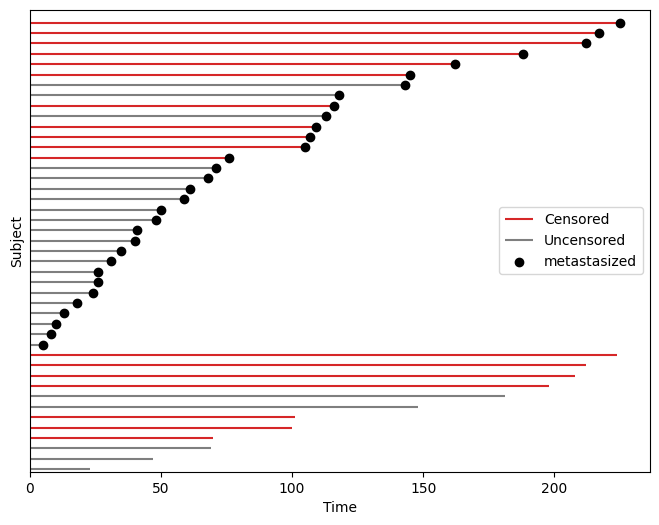

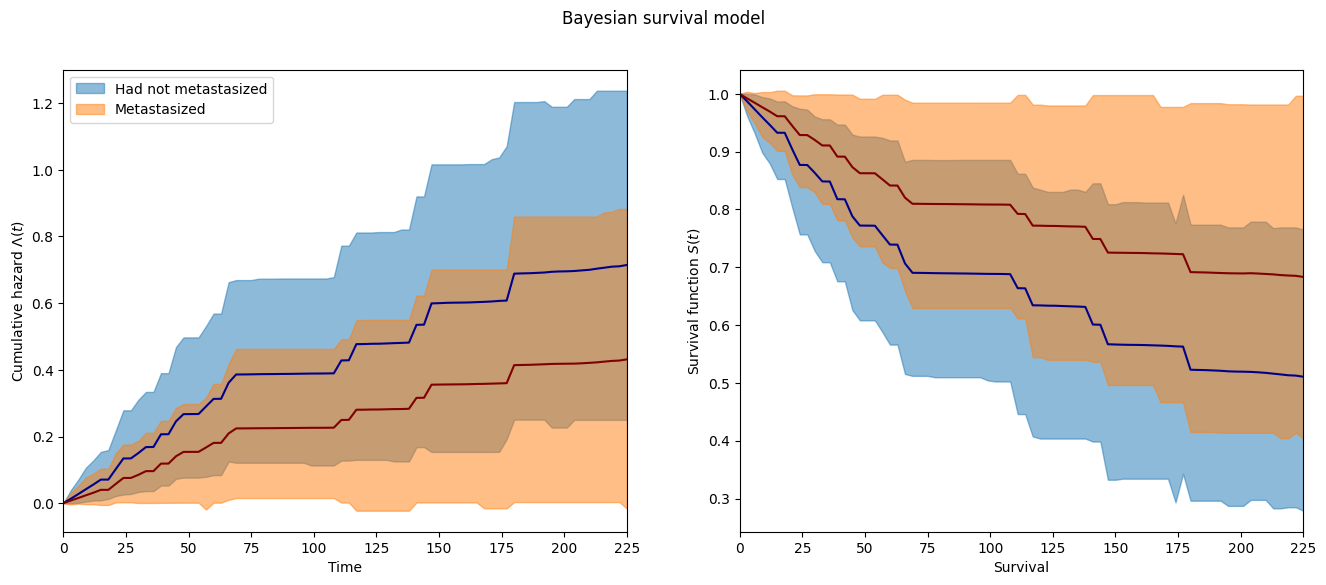

In [1]:
import os
import sys
import numpy as np
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from BI import bi,jnp
# Setup device------------------------------------------------
m = bi(platform='cpu')

# Import Data & Data Manipulation ------------------------------------------------
data_path = os.path.dirname(os.path.abspath("")) + "/BI/resources/data/"
m.data(data_path +'mastectomy.csv', sep=',') # Import

m.df.metastasized = (m.df.metastasized == "yes").astype(np.int64)
m.df.event = jnp.array(m.df.event.values, dtype=jnp.int32)
m.models.survival.surv_object(time='time', event='event', cov='metastasized', interval_length=3)

# Plot censoring ------------------------------------------------
m.models.survival.plot_censoring(cov='metastasized')

# Model ------------------------------------------------
def model(intervals, death, metastasized, exposure):
    # Parameters priors distributions-------------------------
    ## Base hazard distribution
    lambda0 = m.dist.gamma(0.01, 0.01, shape= intervals.shape, name = 'lambda0')

    ## Covariate effect distribution
    beta = m.dist.normal(0, 1000, shape = (1,),  name='beta')

    ## Likelihood
    ### Compute hazard rate based on covariate effect
    lambda_ = m.models.survival.hazard_rate(cov = metastasized, beta = beta, lambda0 = lambda0)
    
    ### Compute exposure rates
    mu = exposure * lambda_

    # Likelihood calculation
    m.dist.poisson(mu + jnp.finfo(mu.dtype).tiny, obs = death)

m.fit(model, num_samples=500) 

m.summary()

m.models.survival.plot_surv()

Alternatively, you can use the `m.models.survival.model` for the built in model. 

  0%|          | 0/1000 [00:00<?, ?it/s]

sample: 100%|██████████| 1000/1000 [00:33<00:00, 29.63it/s, 511 steps of size 6.52e-03. acc. prob=0.95]
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi

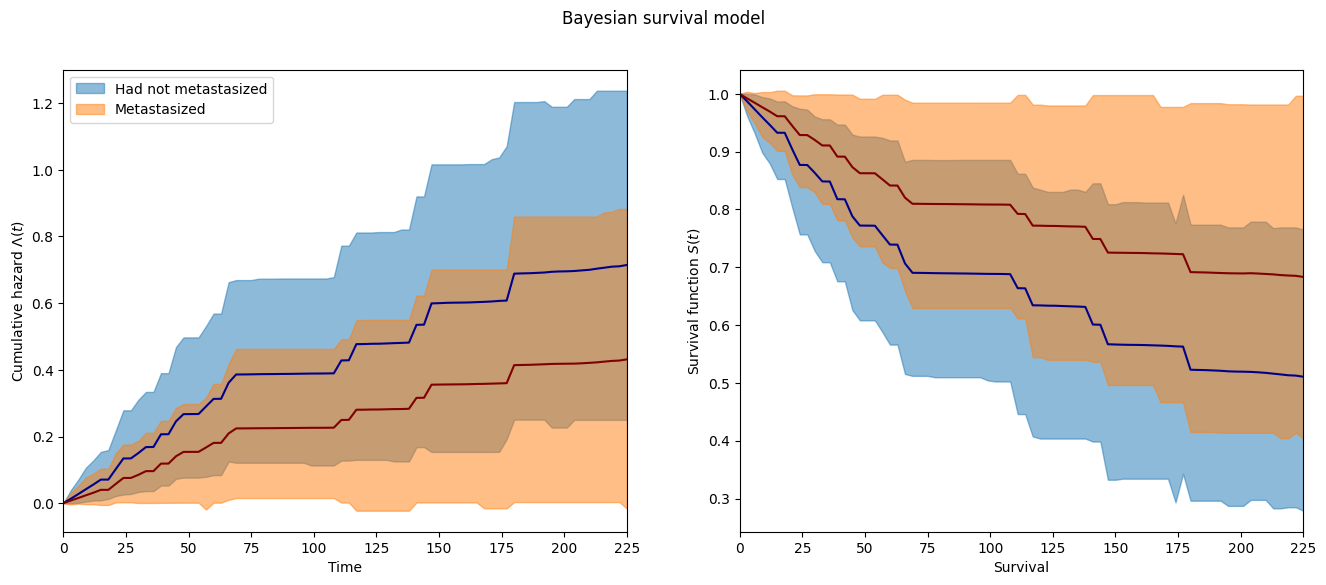

In [2]:
m.fit(m.models.survival.model, num_samples=500) 
m.summary()
m.models.survival.plot_surv()

# Surv object description

In [72]:
from main import *
# Setup device------------------------------------------------
m = bi(platform='cpu')

# Import Data & Data Manipulation ------------------------------------------------
m.data('../resources/data/mastectomy.csv', sep=',') # Import

m.df.metastasized = (m.df.metastasized == "yes").astype(np.int64)
m.df.event = jnp.array(m.df.event.values, dtype=jnp.int32)
m.surv_object(time='time', event='event', cov='metastasized', interval_length=3)

jax.local_device_count 16


In [73]:
m.n_patients

44

In [74]:
m.n_intervals # intervals are m.time.max() + interval_length + 1

76

In [75]:
m.death.shape# Binary matrix (n_patients x n_intervals) indicating whether each subject experienced the event in each interval (1 if the event occurred, 0 otherwise).

(44, 76)

In [76]:
m.death[0,:] 

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [77]:
m.exposure.shape

(44, 76)

In [78]:
m.exposure[0,:] # Matrix (n_patients x n_intervals) indicating the time each subject was exposed in each interval.

array([3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [79]:
m.exposure[43,:]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

# Extension to NBDA  
We can use the survival analysis to evaluate rate of social acquisition versus rate of asocial acquisition. We need simply to generate surv_object for this type of data. 

In [83]:
import os
import sys
newPath = os.path.dirname(os.path.dirname(os.path.abspath("")))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *

bi()
import networkx as nx
import matplotlib.pyplot as plt
# Generating random network (In the future we will use STRAND network generations to include data collection biases)
def create_random_network(n, rate = 0.2, seed=0):
    """
    Create a random network adjacency matrix using the Erdős-Rényi model.
    
    Parameters:
        n (int): Number of nodes in the network.
        rate (float): ate parameter (mean of the distribution), must be >= 0.
        seed (int): Random seed for reproducibility.
        
    Returns:
        jax.numpy.ndarray: Adjacency matrix of the generated random network.
    """
    # Set the random seed for reproducibility
    key = jax.random.PRNGKey(seed)
    
    upper_tri = jax.random.poisson(key,lam = rate,  shape = (n, n))
    lower_tri = upper_tri
    
    # Make the matrix symmetric to represent an undirected graph
    m = upper_tri + lower_tri
    m = m.at[jnp.diag_indices(m.shape[0])].set(0)
    return m

def simulate_social_transmission(m, s=5, baseRate=1/100, BNoise=0.1, seed=0):
    """Simulate a social transmission process in a network.

    Args:
        m (2d array): Network adjacency matrix.
        s (int, optional): Social transmission coefficient. Defaults to 5.
        baseRate (float, optional): Base rate of transmission. Defaults to 1/100.
        BNoise (float, optional): Variance of s. Defaults to 0.1.
        seed (int, optional): Seed for reproducibility. Defaults to 0.

    Returns:
        tuple: Two arrays, time of acquisition and order of acquisition.
    """
    key = jax.random.PRNGKey(seed)
    N = m.shape[0]

    # Initialize the asocial learning propensity for all nodes to 1
    asocialLP = jnp.ones(N)

    # Social transmission coefficient vector with noise
    key, subkey = jax.random.split(key)
    BVect = jnp.exp(jax.random.normal(subkey, (N,)) * BNoise + jnp.log(2))

    # Arrays for acquisition status, acquisition order, and acquisition time
    z = jnp.zeros(N)
    orderAcq = jnp.zeros(N, dtype=int)
    timeAcq = jnp.zeros(N)

    runningTime = 0

    # Define the step function for the simulation
    def step(i, state):
        z, runningTime, orderAcq, timeAcq, key = state

        # m is transposed to account for the *i* propensity to transmit information to *j* proportional to *j*'s link weights toward *i*
        # We retranspose this matrix to get the i,j reading order.
        # We multiply it by *z* to have information on individual *i*'s status.
        # We multiply it by *s* to amplify the social influence effect, scaling how strongly an individual's status influences their neighbors.
        # This results in a transmission rate that combines asocial learning and weighted social influence, indicating the likelihood of transmission to each node.
        rate = baseRate * (jnp.exp(asocialLP) + s * (z @ (m.T * BVect).T)) * (1 - z)

        # Sample the time until the next transmission event
        key, subkey = jax.random.split(key)
        times = jax.random.exponential(subkey, shape=(N,)) / rate

        # Find the next individual to acquire the trait
        min_idx = jnp.argmin(times)
        min_time = times[min_idx]

        # Update cumulative time and acquisition status
        runningTime += min_time
        timeAcq = timeAcq.at[min_idx].set(runningTime)
        orderAcq = orderAcq.at[i].set(min_idx)
        z = z.at[min_idx].set(1)

        return z, runningTime, orderAcq, timeAcq, key

    # Use `lax.scan` to loop through each transmission step
    z, runningTime, orderAcq, timeAcq, _ = jax.lax.fori_loop(0, N, step, (z, runningTime, orderAcq, timeAcq, key))

    return timeAcq, orderAcq

jax.local_device_count 16


In [84]:
# Create a random network adjacency matrix with 100 nodes and a connection rate of 0.2
network = create_random_network(10, rate=0.5)
network

Array([[0, 2, 0, 4, 2, 0, 2, 2, 0, 4],
       [0, 0, 0, 2, 2, 0, 0, 0, 2, 0],
       [2, 4, 0, 0, 2, 2, 0, 8, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 4, 0],
       [0, 0, 2, 0, 0, 2, 2, 0, 0, 2],
       [2, 0, 2, 0, 4, 0, 2, 2, 2, 2],
       [0, 2, 0, 0, 4, 2, 0, 0, 4, 0],
       [0, 2, 4, 2, 2, 0, 4, 0, 2, 2],
       [2, 0, 2, 0, 0, 0, 0, 0, 0, 2],
       [2, 2, 0, 4, 2, 2, 0, 2, 0, 0]], dtype=int32)

In [85]:
StimeAcq, SorderAcq = simulate_social_transmission(network, s=5, BNoise=0.1, seed=0)
SorderAcq

Array([8, 2, 0, 7, 1, 6, 3, 9, 4, 5], dtype=int64)

In [86]:
def get_status_by_t(SolveOrders): 
    times = len(SolveOrders)
    N_id = len(SolveOrders)
    z_i = jnp.zeros((N_id, times))
    for t in range(times):
        z_i = z_i.at[t, SolveOrders[:t+1] - 1].set(1)
    
    Zt0 = jnp.vstack([jnp.zeros(z_i.shape[1]), z_i])
    #Zt0 = jnp.delete(Zt0, -1, axis=0)
    return Zt0, Zt0[0:Zt0.shape[0]-1,:], Zt0[1:Zt0.shape[0],:],
Z, Zt0, Zt1  = get_status_by_t(SorderAcq)
Z.T # this is the equivalent of death matrix in survival object

Array([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float64)

In [160]:
# Parameters priors distributions-------------------------
## Base hazard distribution
lambda0 = bi.dist.gamma(0.01, 0.01, shape= Zt0.T.shape, name ='lambda0', sample=True)
## Covariate effect distribution
beta = bi.dist.normal(0, 1000, shape = (1,),  name='beta',sample=True)


In [161]:
# Now we need to encode a varying covariate that represent for an in individual i, the sum of links weights with informed individuals for each time steps.
# For this we multiply each column of Z.T with the network matrix and then sum by row.
# Example at time t = 0
Zt0.T[:,0] * network # As no one is informed at time 0, we have a 0 in the first column
# Example at time t = 1
tmp= Zt0.T[:,1] * network 
print(tmp)# As only individual 8 is informed at time 1, we have only its connections that are non-zero
print(jnp.sum(tmp, axis=1)) # We sum the columns to get the sum of the links weights with informed individuals at time 1 and rea5ise the dot product woth the c oefficient beta

t=jax.vmap(lambda x:x@(network*beta), in_axes=1)(Zt0.T).T
t

[[0. 0. 0. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0.]]
[2. 0. 8. 0. 0. 2. 0. 0. 0. 2.]


Array([[     0.        ,      0.        ,      0.        ,
         -1569.53155289,  -1569.53155289,  -1569.53155289,
         -3139.06310579,  -4708.59465868,  -6278.12621157,
         -6278.12621157],
       [     0.        ,  -1569.53155289,  -1569.53155289,
         -3139.06310579,  -4708.59465868,  -6278.12621157,
         -6278.12621157,  -9417.18931736,  -9417.18931736,
         -9417.18931736],
       [     0.        ,  -3139.06310579,  -3139.06310579,
         -3139.06310579,  -3139.06310579,  -3139.06310579,
         -4708.59465868,  -4708.59465868,  -6278.12621157,
         -6278.12621157],
       [     0.        ,  -1569.53155289,  -3139.06310579,
         -6278.12621157,  -6278.12621157,  -9417.18931736,
         -9417.18931736,  -9417.18931736,  -9417.18931736,
         -9417.18931736],
       [     0.        ,  -1569.53155289,  -3139.06310579,
         -4708.59465868,  -7847.65776447,  -9417.18931736,
        -12556.25242315, -14125.78397604, -14125.78397604,
        -15

In [164]:
t.shape # we now need to add asocia-rate, the result is the likelihood and the output is Zt1.shape

(10, 10)

In [165]:
Zt1.shape

(10, 10)